In [1]:
import bonesis
import pandas as pd
from colomoto_jupyter import tabulate

In [2]:
import biolqm, ginsim

## Loading bnet model and importing its influence graph in Bonesis

In [3]:
model = biolqm.load("../pymaboss/model_ens/old/template.bnet")
gs_model = biolqm.to_ginsim(model)
exact_pkn = True
maxclause = 32

# computing graph layout...


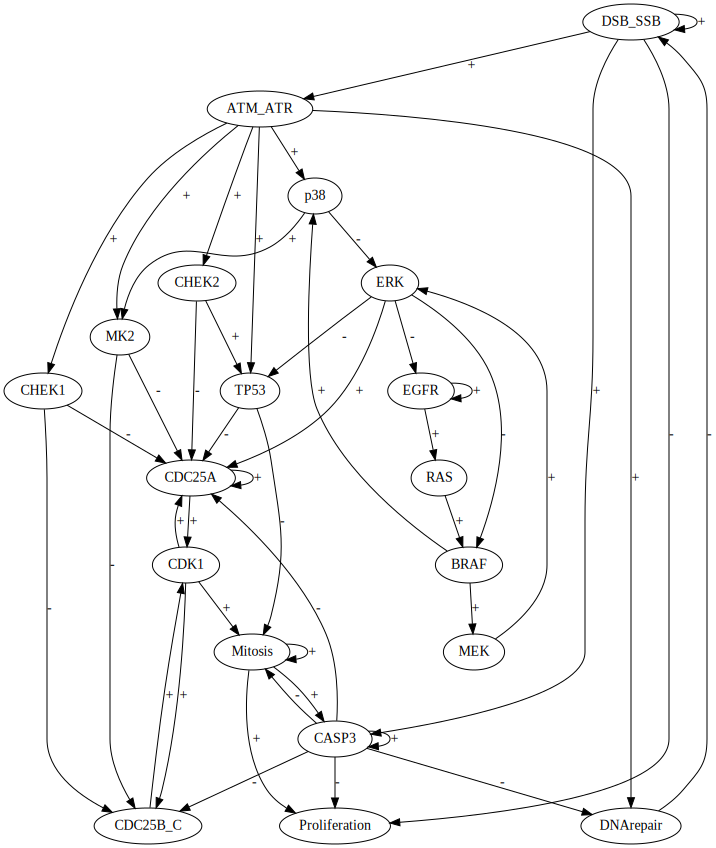

In [4]:
dom1 = bonesis.InfluenceGraph.from_ginsim(gs_model, exact=exact_pkn, maxclause=maxclause)
dom1

## Adding dataset for constraints (nothing here)

In [5]:
data = {}

## Adding fixed logic : Which node's formula is fixed, which one has several possibilities

In [6]:
from bonesis0.asp_encoding import string_of_facts
from colomoto.minibn import BooleanNetwork
import clingo

In [7]:
fixed = BooleanNetwork({
    "EGFR": "!ERK&EGFR",
    "RAS": "EGFR",
    "BRAF": "RAS&!ERK",
    "MEK": "BRAF",
    "ERK": "MEK&!p38",
    "p38": "(ATM_ATR|BRAF)",
    "MK2": "p38&ATM_ATR",
    "CDC25B_C": "(!CHEK1&!MK2&!CASP3)&CDK1",
    "CDK1": "(CDC25A|CDC25B_C)",
    "DSB_SSB": "DSB_SSB&!DNArepair",
    "DNArepair": "ATM_ATR&!CASP3",
    "ATM_ATR": "DSB_SSB",
    "CHEK2": "ATM_ATR",
    "Mitosis": "(!TP53 & CDK1 & !CASP3) | Mitosis",
    "Proliferation": "Mitosis&!CASP3&!DSB_SSB"
})
choices = {
    "CHEK1": ['ATM_ATR|p38','ATM_ATR'],
    "CASP3": ['(DSB_SSB&Mitosis) | CASP3', '(DSB_SSB&Mitosis)|(TP53&DSB_SSB)|CASP3'],
    "TP53": ['!ERK & (CHEK2|ATM_ATR)','!(ERK|MEK) & (CHEK2|ATM_ATR)'],
    "CDC25A": ['(ERK|CDC25A|CDK1)&(!CHEK1&!MK2&!CHEK2&!TP53&!CASP3)',
               '((ERK|MEK)|CDC25A|CDK1)&(!CHEK1&!MK2&!CHEK2&!TP53&!CASP3)'
              ]
}
choices = {n: [fixed.ba.parse(f) for f in fs] for n, fs in choices.items()}

In [8]:
bo = bonesis.BoNesis(dom1, data)

In [9]:
# remove input edges from influence graph
for n in list(fixed) + list(choices):
    dom1.remove_edges_from(list(dom1.in_edges(n)))

# fixed logic
for n, f in fixed.items():
    bo.custom(string_of_facts(bo.aspmodel.encode_BooleanFunction(n, f)))

# choices
bo.custom("clause(N,C,L,S) :- select_function(N,K), select_clause(N,K,C,L,S)")
bo.custom("constant(N,V) :- select_function(N,K), select_constant(N,K,V)")
for n, fs in choices.items():
    bo.custom(f"1 {{select_function({clingo.String(n)}, 0..{len(fs)-1})}} 1")
    for k, f in enumerate(fs):
        facts = bo.aspmodel.encode_BooleanFunction(n, f)
        facts = [clingo.Function(f"select_{fu.name}", 
                        [fu.arguments[0], clingo.Number(k)]+fu.arguments[1:])
                for fu in facts]
        bo.custom(string_of_facts(facts))

## Building the ensemble

In [10]:
solutions = list(bo.boolean_networks())
pd.DataFrame(solutions)

Grounding...done in 0.0s


,ATM_ATR,BRAF,CASP3,CDC25A,CDC25B_C,CDK1,CHEK1,CHEK2,DNArepair,DSB_SSB,EGFR,ERK,MEK,MK2,Mitosis,Proliferation,RAS,TP53,p38
0,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(ATM_ATR&!ERK)|(CHEK2&!ERK),ATM_ATR|BRAF
1,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR|p38,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(ATM_ATR&!ERK)|(CHEK2&!ERK),ATM_ATR|BRAF
2,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis)|(DSB_SSB&TP53),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR|p38,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(!MEK&ATM_ATR&!ERK)|(CHEK2&!MEK&!ERK),ATM_ATR|BRAF
3,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis)|(DSB_SSB&TP53),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(!MEK&ATM_ATR&!ERK)|(CHEK2&!MEK&!ERK),ATM_ATR|BRAF
4,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR|p38,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(!MEK&ATM_ATR&!ERK)|(CHEK2&!MEK&!ERK),ATM_ATR|BRAF
5,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis)|(DSB_SSB&TP53),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR|p38,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(ATM_ATR&!ERK)|(CHEK2&!ERK),ATM_ATR|BRAF
6,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR|p38,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(!MEK&ATM_ATR&!ERK)|(CHEK2&!MEK&!ERK),ATM_ATR|BRAF
7,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis)|(DSB_SSB&TP53),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(!MEK&ATM_ATR&!ERK)|(CHEK2&!MEK&!ERK),ATM_ATR|BRAF
8,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis)|(DSB_SSB&TP53),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(ATM_ATR&!ERK)|(CHEK2&!ERK),ATM_ATR|BRAF
9,DSB_SSB,RAS&!ERK,CASP3|(DSB_SSB&Mitosis)|(DSB_SSB&TP53),(!MK2&!CHEK2&CDC25A&!CHEK1&!TP53&!CASP3)|(!MK2...,!CASP3&!MK2&CDK1&!CHEK1,CDC25A|CDC25B_C,ATM_ATR|p38,ATM_ATR,!CASP3&ATM_ATR,DSB_SSB&!DNArepair,EGFR&!ERK,MEK&!p38,BRAF,p38&ATM_ATR,Mitosis|(!CASP3&CDK1&!TP53),!CASP3&!DSB_SSB&Mitosis,EGFR,(ATM_ATR&!ERK)|(CHEK2&!ERK),ATM_ATR|BRAF


In [12]:
import os

if not os.path.exists("first_example"):
    os.mkdir("first_example")

for i, solution in enumerate(solutions):
    
    model = solution.to_biolqm()
    biolqm.save(model, "first_example/model_%d.bnet" % i)